# ASTR 154 Final Project

Can we accurately classify stars in an open cluster such as Pleiades into evolutionary stages (main sequence, subgiant, giant, etc.) using machine learning models, Random Forest Classifer and K-Nearest Neighbors based on their brightness, color, and motion through space? Which machine learning model performs best based on looking at their interpretability components such as accuracy

### Methods Used:
- ML Models: Random Forest Classifier, K-Nearest Neighbors (Non-Linear Classifier)
- Interpretability: Cross-Validation, Accuracy Score, F1 Score
- Good Coding Practices
- Relational Databases (SQL Formatting)
- Version Control (Commit + Push into GitHub)
- Scientific Programming

### Interesting Notes:
- Hertzsprung-Russell (HR) diagram classifies stars based on their absolute magnitude and color index (spectral type). Knowing where a star lies on the HR Diagram can help astronomers understand where stars are in their evolutionary stages.
- Pleiades are made of hot, blue, B-type stars, or B-type Main Sequence Stars. This cluster of stars is relatively young, at the age of 100 million years old. (This means we should expect from approximating the evolutionary stages of the stars to primarily consist of Main Sequence stars.)
- Pleiades are significantly more massive and luminous than the Sun and have high surface temperatures. They are also known to have a bright blue appearence.

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer

In [2]:
from astroquery.gaia import Gaia # Gaia DR3 database

# Coordinates of Pleiades' center
ra_pleiades = 56.75     # degrees
dec_pleiades = 24.12    # degrees
radius_deg = 2.0        # search radius in degrees

# Query to select stars around Pleiades with reasonable parallax and proper motion filters
query = f"""
SELECT
    source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag,
    phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra_pleiades}, {dec_pleiades}, {radius_deg})
)
AND parallax BETWEEN 5 AND 10
AND pmra BETWEEN 15 AND 25
AND pmdec BETWEEN -55 AND -40
"""

job = Gaia.launch_job_async(query)
results = job.get_results()

# Convert to DataFrame
pleiades_df = results.to_pandas()
pleiades_df.head()


Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Wednesday 4th from 11h to 12h
INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,65588484235454592,58.268967,22.801153,7.293433,19.036700,-45.560948,13.100869,13.850247,12.250756
1,65589137070475264,58.315505,22.870487,7.730451,19.499144,-47.304899,15.532084,17.030619,14.332067
2,65603946117575936,58.256849,22.979900,7.420786,18.679104,-45.228349,16.564484,18.348476,15.292192
3,65605354866829184,58.292407,23.052791,7.339354,19.736553,-46.536112,15.395707,16.808872,14.223000
4,65626623544976768,58.655746,23.225565,7.137677,19.005756,-43.622189,16.585747,18.357910,15.306788


##### RA and DEC are the right ascension and declination of the star. PMRA and PMDEC is the proper motion in right ascension and declination. Phot_g_mean_mag, phot_bp_mean_mag, and phot_rp_mean_mag, are G-band mean magnitude, blue photometer mean magnitude, and red photometer mean magnitude. They represent the brightness in the green, blue, and red spectrum.

In [3]:
# Curious about how many stars were returned?
print(f"Number of stars returned: {len(results)}")

Number of stars returned: 1068


### Begin ML Model Training - Visualize Feature Space

In [4]:
# Select features
pleiades_df["temperature"] = pleiades_df["phot_bp_mean_mag"] - pleiades_df["phot_rp_mean_mag"] # using color spectrum to determine the temperature of stars
pleiades_df["cool_star"] = (pleiades_df["temperature"] > 1.5).astype(int)
pleiades_df["total_pm"] = np.sqrt(pleiades_df["pmra"]**2 + pleiades_df["pmdec"]**2) # proper motion of a star to determine how fast it is moving
pleiades_df["is_pleiades"] = (pleiades_df["parallax"].between(6.5, 7.5)) & (pleiades_df["pmra"].between(17, 21)) & (pleiades_df["pmdec"].between(-50, -43)).astype(int)

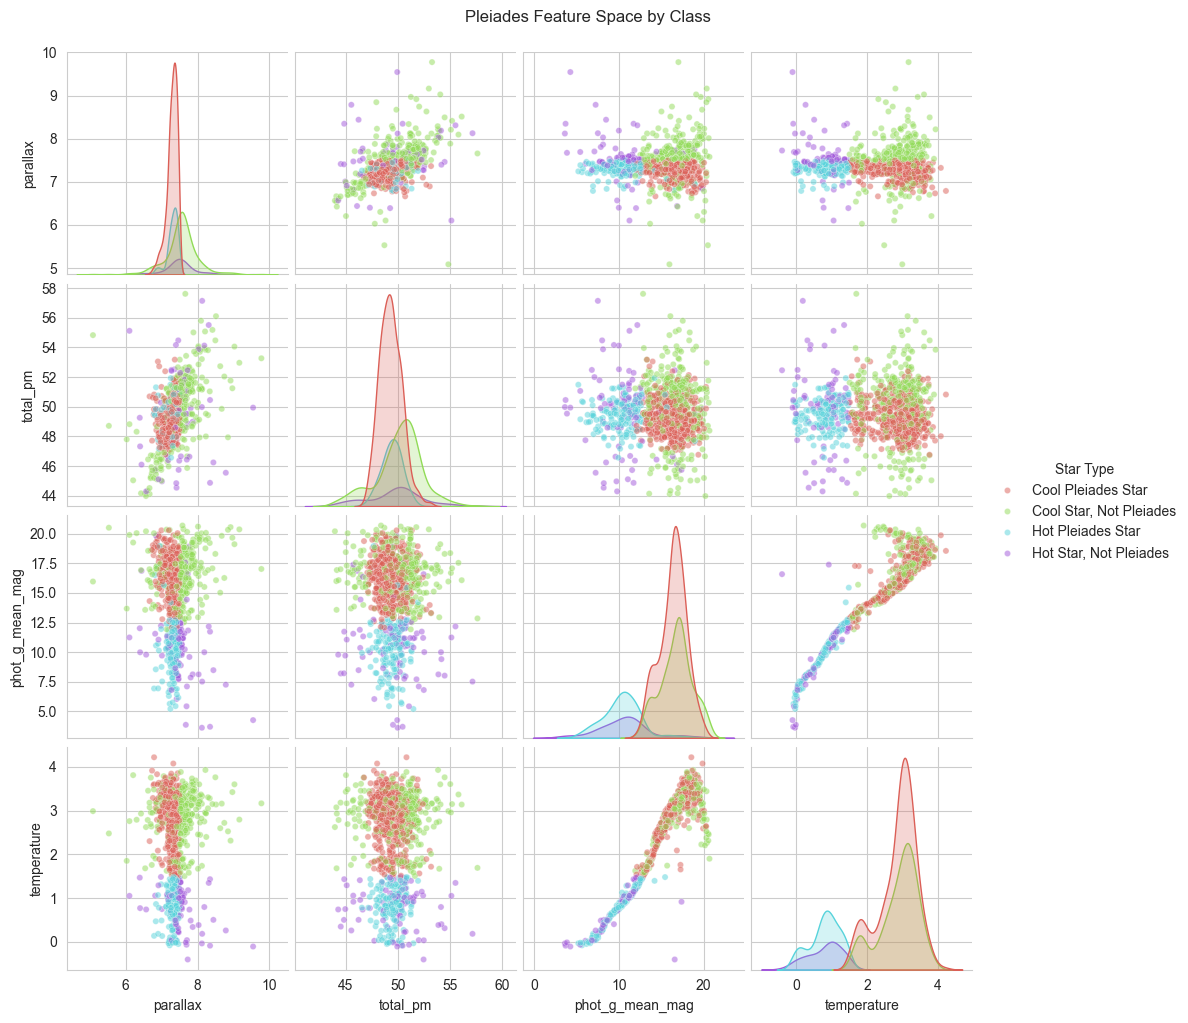

In [5]:
import seaborn as sns

features = ["phot_g_mean_mag", "temperature", "parallax", "total_pm"]
pleiades_df["label"] = pleiades_df["is_pleiades"] * 2 + pleiades_df["cool_star"]

pleiades_df["Star Type"] = pleiades_df["label"].map({
    0: "Hot Star, Not Pleiades",
    1: "Cool Star, Not Pleiades",
    2: "Hot Pleiades Star",
    3: "Cool Pleiades Star"
})

x = pleiades_df[features]
y = pleiades_df["Star Type"]

plot_df = pleiades_df[["parallax", "total_pm", "phot_g_mean_mag", "temperature", "Star Type"]]

# Plot the pairwise feature space colored by class
sns.pairplot(plot_df, hue='Star Type', palette="hls", diag_kind="kde", plot_kws={"alpha": 0.5, "s": 20})
plt.suptitle("Pleiades Feature Space by Class", y=1.02)
plt.show()

#### Random Forest Classification

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

Random Forest Classifier Accuracy: 0.88
Log Loss: 0.61

Classification Report:
                          precision    recall  f1-score   support

     Cool Pleiades Star       0.87      0.96      0.91        99
Cool Star, Not Pleiades       0.92      0.77      0.84        62
      Hot Pleiades Star       0.81      0.97      0.88        31
 Hot Star, Not Pleiades       0.94      0.68      0.79        22

               accuracy                           0.88       214
              macro avg       0.89      0.85      0.86       214
           weighted avg       0.88      0.88      0.88       214



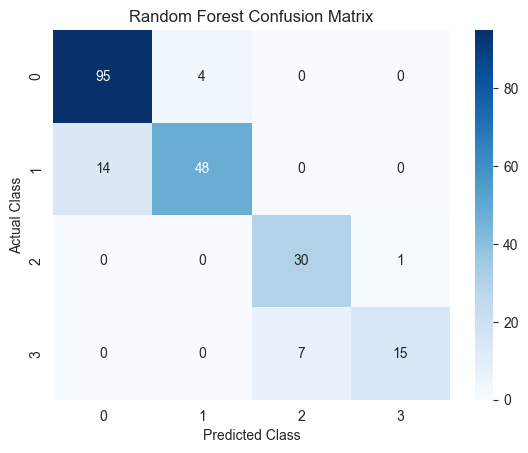

In [7]:
x = pleiades_df[features]
y = pleiades_df["Star Type"]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(x_train, y_train)

# Predictions
y_pred = rfc.predict(x_test)
y_prob = rfc.predict_proba(x_test)

# Evaluate its accuracy
rfc_accuracy = accuracy_score(y_test, y_pred)
rfc_ll = log_loss(y_test, y_prob)
print(f"Random Forest Classifier Accuracy: {rfc_accuracy:.2f}")
print(f"Log Loss: {rfc_ll:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
rfc_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(rfc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

#### K-Nearest Neighbors Classification

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

K-Nearest Neighbors Accuracy: 0.85
Log Loss: 2.43

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.40      0.55        15
           1       0.88      0.72      0.79        64
           2       0.83      0.97      0.89        35
           3       0.84      0.96      0.89        97

    accuracy                           0.85       211
   macro avg       0.85      0.76      0.78       211
weighted avg       0.85      0.85      0.84       211



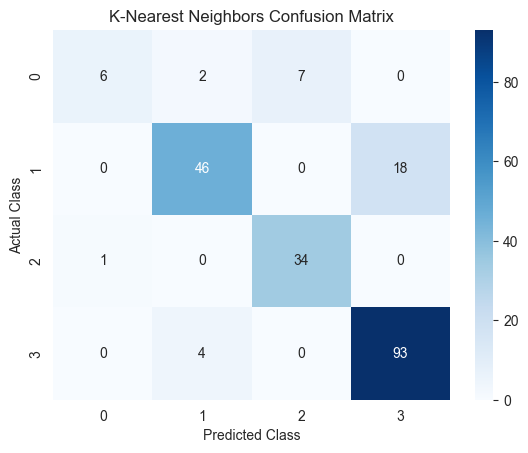

In [9]:
# drop rows with NaNs in the features and labels
df_clean = pleiades_df.dropna(subset=features + ["label"])
x_clean = df_clean[features]
y_clean = df_clean["label"]

# train/test split new x and y
x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size=0.2, random_state=42)

# Normalize Features for KNN
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # without normalization, KNN's accuracy is very low in comparison to RFClassifier

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# Predictions
y_pred_knn = knn.predict(x_test)
y_prob_knn = knn.predict_proba(x_test)

# Evaluate its accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_ll = log_loss(y_test, y_prob_knn)
print(f"K-Nearest Neighbors Accuracy: {knn_accuracy:.2f}")
print(f"Log Loss: {knn_ll:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix Plot
knn_cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues")
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

##### Conclusion we can make so far: Based on visualizing the feature space, we can conclude that Random Forest Classification outperforms KNN. It has a higher accuracy score and a lower log loss score whereas KNN has a comparable accuracy score, but a significantly higher log loss score. RFC also has a higher F1 Score in all of the categories than KNN meaning the positive predictions that it made were actually correct.

### Classify Stars into their Evolutionary Stages

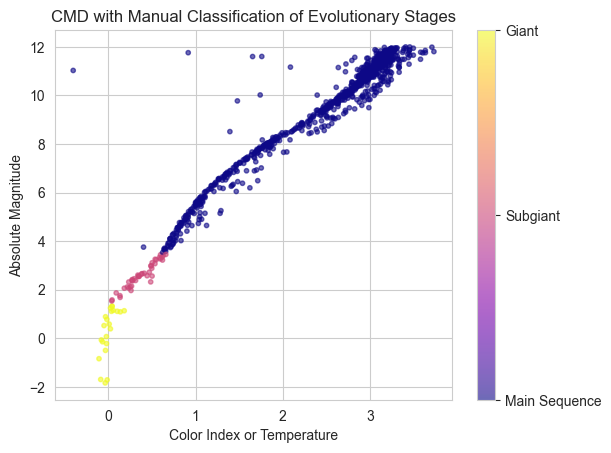

In [14]:
# define absolute magnitude function and color index function
pleiades_df["distance_pc"] = 1000 / pleiades_df["parallax"]
abs_mag = pleiades_df["phot_g_mean_mag"] - 5 * np.log10(pleiades_df["distance_pc"])+5
temperature = pleiades_df["phot_bp_mean_mag"] - pleiades_df["phot_rp_mean_mag"]

# apply a filter and then recompute absolute magnitude and color index
pleiades_df = pleiades_df[abs_mag < 12].copy() # filters out faint stars
abs_mag = pleiades_df["phot_g_mean_mag"] - 5 * np.log10(pleiades_df["distance_pc"])+5
temperature = pleiades_df["phot_bp_mean_mag"] - pleiades_df["phot_rp_mean_mag"]

# Create and adjust conditions for classification of the stars' evolutionary stages
conditions = [
    (abs_mag > 3.5),  # Main Sequence
    (abs_mag <= 3.5) & (abs_mag > 1.5),  # Subgiants
    (abs_mag <= 1.5),  # Giants
] # manual interpretation of evolutionary stages
labels = [0, 1, 2]  # 0 = MS, 1 = Subgiant, 2 = Giant

pleiades_df["evo_stage"] = np.select(conditions, labels, default=np.nan)

# Plot CMD (color-magnitude diagram)
scatter = plt.scatter(temperature, abs_mag, c=pleiades_df["evo_stage"], cmap='plasma', s=10, alpha=0.6)
plt.xlabel("Color Index or Temperature")
plt.ylabel("Absolute Magnitude")
plt.title("CMD with Manual Classification of Evolutionary Stages")
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["Main Sequence", "Subgiant", "Giant"])
plt.grid(True)
plt.show()

##### From this plot, we see that most of the stars in the Pleiades cluster belong to the Main Sequence stage. This makes sense because the cluster is known to have many stars that are B-Type Main Sequence so our approximation and manual conditions make sense and align with what is known about them.

#### Train using Random Forest Classifier

Random Forest Accuracy: 0.9942857142857143
Log Loss: 0.6132039962955413

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       164
         1.0       0.83      1.00      0.91         5
         2.0       1.00      1.00      1.00         6

    accuracy                           0.99       175
   macro avg       0.94      1.00      0.97       175
weighted avg       1.00      0.99      0.99       175



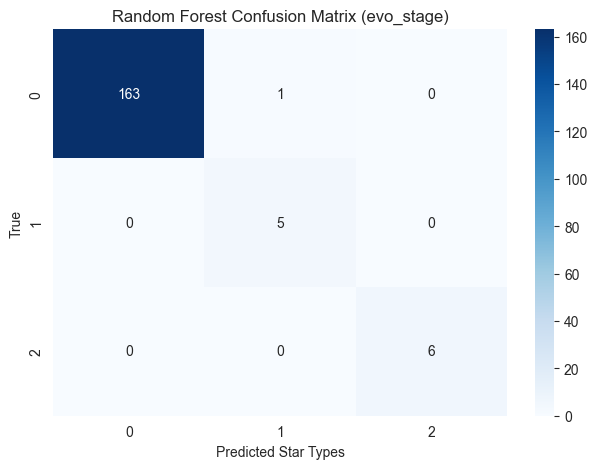

In [15]:
features = ["parallax", "temperature", "phot_g_mean_mag"]
x = pleiades_df[features]
y = pleiades_df["evo_stage"]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)

# Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(x_train, y_train)

# Predictions
y_pred = rfc.predict(x_test)
y_prob = rfc.predict_proba(x_test)
rfc_es_ll = log_loss(y_test, y_prob) # evolutionary stage log loss

# Evaluate its accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", rfc_ll)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
rfc_es_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(rfc_es_cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Star Types")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix (evo_stage)")
plt.tight_layout()
plt.show()

#### Train using KNN Classification

KNN Accuracy: 0.9813953488372092
Log Loss: 0.03941601435388851

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       199
         1.0       0.89      0.73      0.80        11
         2.0       0.83      1.00      0.91         5

    accuracy                           0.98       215
   macro avg       0.90      0.91      0.90       215
weighted avg       0.98      0.98      0.98       215



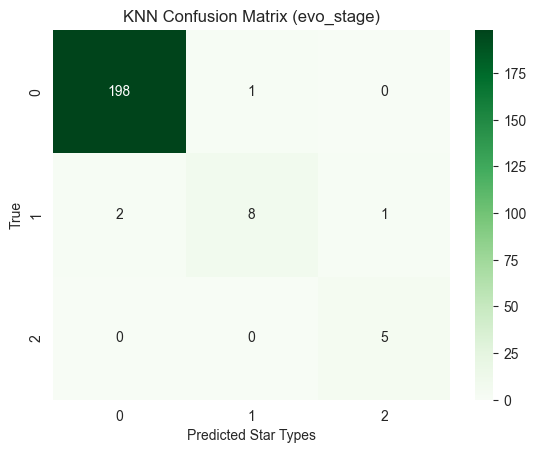

In [16]:
knn_df = pleiades_df.dropna(subset=features + ["evo_stage"]).copy()

X_KNN = knn_df[features]
Y_KNN = knn_df["evo_stage"]

X_train, X_test, Y_train, Y_test = train_test_split(X_KNN, Y_KNN, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, Y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)
knn_es_ll = log_loss(Y_test, y_prob_knn)

print("KNN Accuracy:", accuracy_score(Y_test, y_pred_knn))
print("Log Loss:", knn_es_ll)
print("\nKNN Classification Report:\n", classification_report(Y_test, y_pred_knn))

cm_knn = confusion_matrix(Y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Star Types")
plt.ylabel("True")
plt.title("KNN Confusion Matrix (evo_stage)")
plt.show()

In [17]:
from sklearn.model_selection import cross_val_score
cv_knn = cross_val_score(knn, X_KNN, Y_KNN, cv=5)
cv_rfc = cross_val_score(rfc, x, y, cv=5)

print("KNN CV Accuracy:", cv_knn.mean())
print("RFC CV Accuracy:", cv_rfc.mean())

KNN CV Accuracy: 0.9964980280157759
RFC CV Accuracy: 0.9965517241379311


Explained variance ratio: [0.65755536 0.33199923]
Total variance explained:, 98.96%
First 2 Components: [[-0.73890444 -0.30929137]
 [ 0.53251529  1.23418156]
 [ 1.101185    0.23799891]
 ...
 [ 0.63159393  1.42086049]
 [ 1.33271666  1.85993606]
 [-0.99866276 -0.2760735 ]]
PC1:
  parallax: -0.065
  temperature: 0.705
  phot_g_mean_mag: 0.706
PC2:
  parallax: 0.998
  temperature: 0.054
  phot_g_mean_mag: 0.038


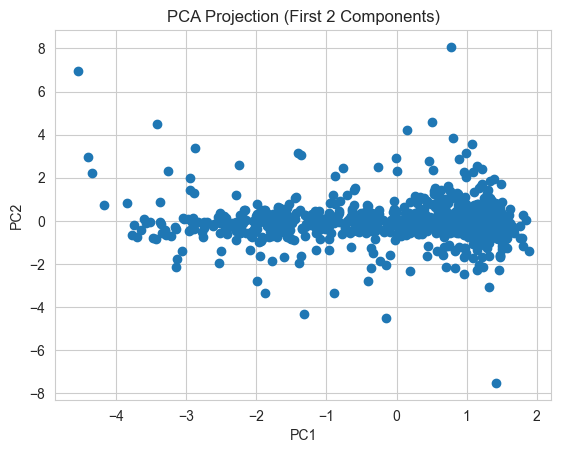

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_scaled = StandardScaler().fit_transform(X_KNN) # using X_KNN because I dropped NaNs in the features
pca = PCA(n_components=2)
pca_x = pca.fit_transform(x_scaled)

variance = pca.explained_variance_ratio_
print("Explained variance ratio:", variance)
total_variance = variance.sum()
print(f"Total variance explained:, {total_variance:.2%}")
print("First 2 Components:", pca_x[:, :2])
for i, component in enumerate(pca.components_):
    print(f"PC{i+1}:")
    for feature, weight in zip(features, component):
        print(f"  {feature}: {weight:.3f}")

plt.scatter(pca_x[:, 0], pca_x[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (First 2 Components)")
plt.show()